<a href="https://colab.research.google.com/github/jtsuvile/coding_challenges/blob/main/testing_generative_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentals on creating generative art with R

Steps of the workshop:
1. what is R and how do we run this thing? (running code, notebooks)
2. what are plots and how we create them? (link to colors)
3. introducing randomness(?) to the process (introduce the concept of seed)
4. a couple of different types of plots you can play around with
5. time to experiment 
6. list of resources for future study

These materials borrow a lot from Danielle Navarro's fantastic course "Art from code". All of her course materials are available at https://art-from-code.netlify.app/.

# Step 1: set-up (everyone should do this)

In [1]:
system("apt-get -y update")
system("apt-get install -y libudunits2-dev libgdal-dev libgeos-dev libproj-dev r-base-dev libmagick++-dev")

In [27]:
# We install packages that will get used during the session
install.packages(c("mapproj", "ggforce", "Rcpp","maps", "tweenr", "polyclip", "RcppEigen", "aRtsy"))
devtools::install_github("marcusvolz/mathart")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(repr)
library(ggplot2)
library(dplyr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Generative art from sine and cosine curves

In [ ]:
# create a data frame from our formula
generate_data <- function(formula) {
  print("generate data")
  df <- seq(from = -pi, to = pi, by = 0.01) %>%
    expand.grid(x_i = ., y_i = .) %>%
    dplyr::mutate(!!!formula)
  return(df)
}

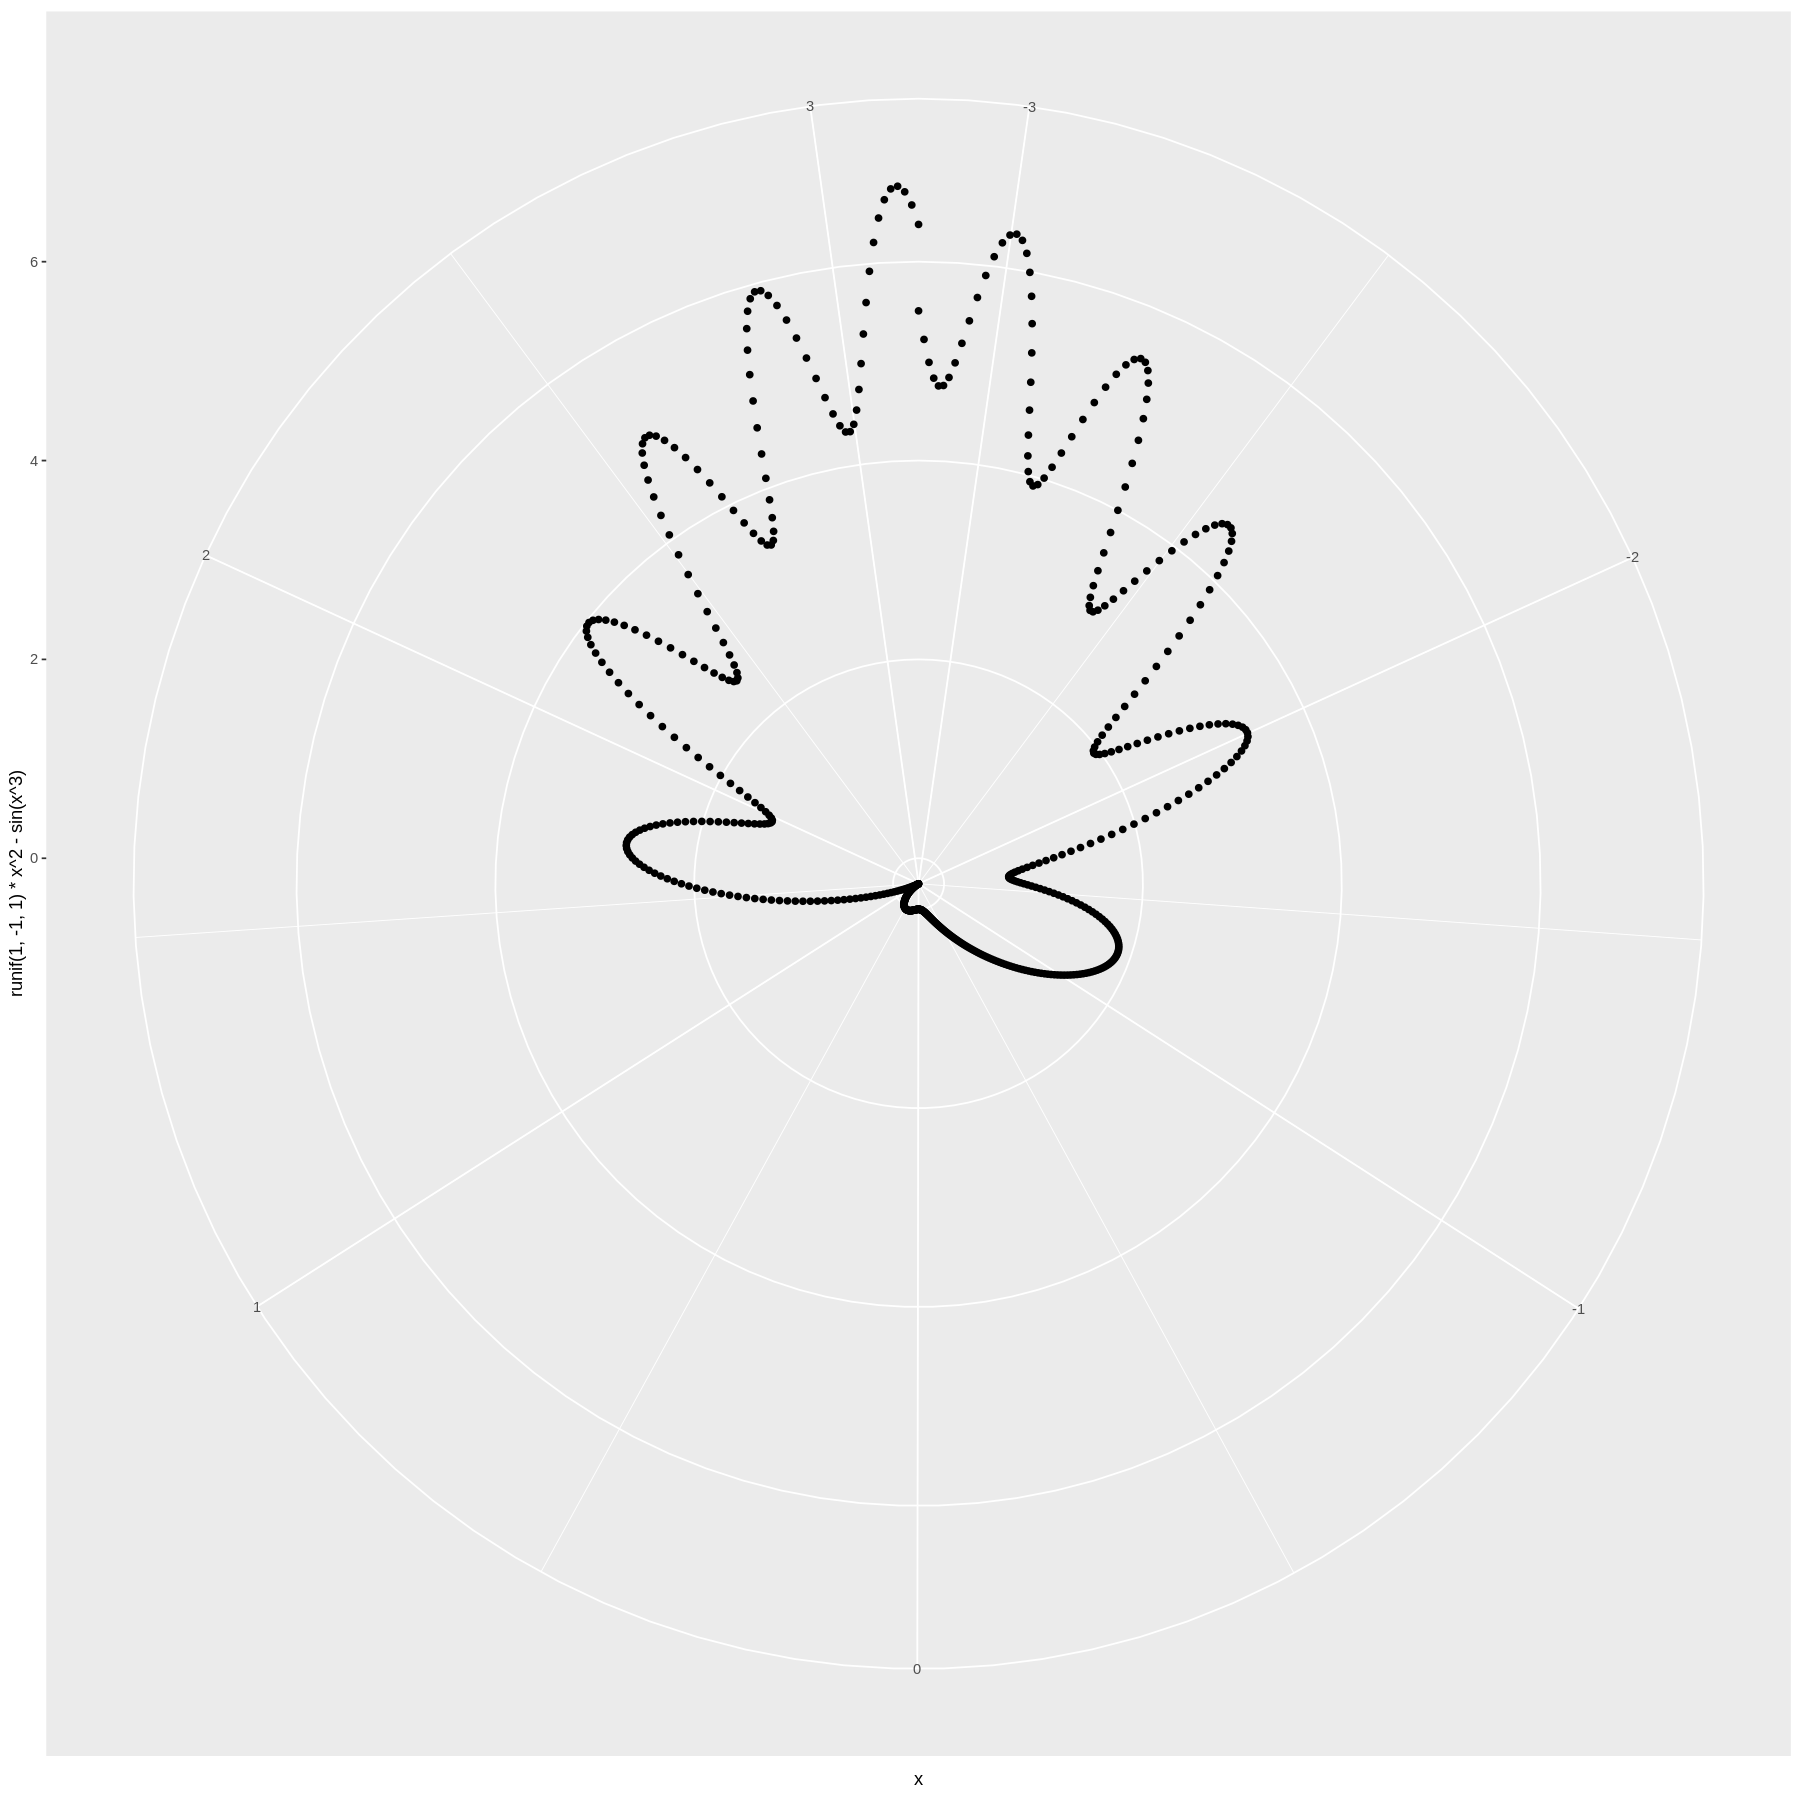

In [ ]:
data_sequence = data.frame(x = seq(from = -pi, to = pi, by = 0.01))
#data_sequence
ggplot(data=data_sequence, aes(x=x, y=runif(1, -1, 1) * x^2 - sin(x^3))) +
  geom_point() + 
  coord_polar()

In [ ]:
my_formula <- list(
  x = quote(runif(1, -1, 1) * x_i^2 - sin(y_i^3)),
  y = quote(runif(1, -1, 1) * y_i^3 - cos(x_i^2))
)

In [ ]:
seed <- sample(1:10000, 1)
set.seed(seed)
df <- generate_data(my_formula)

[1] "generate data"


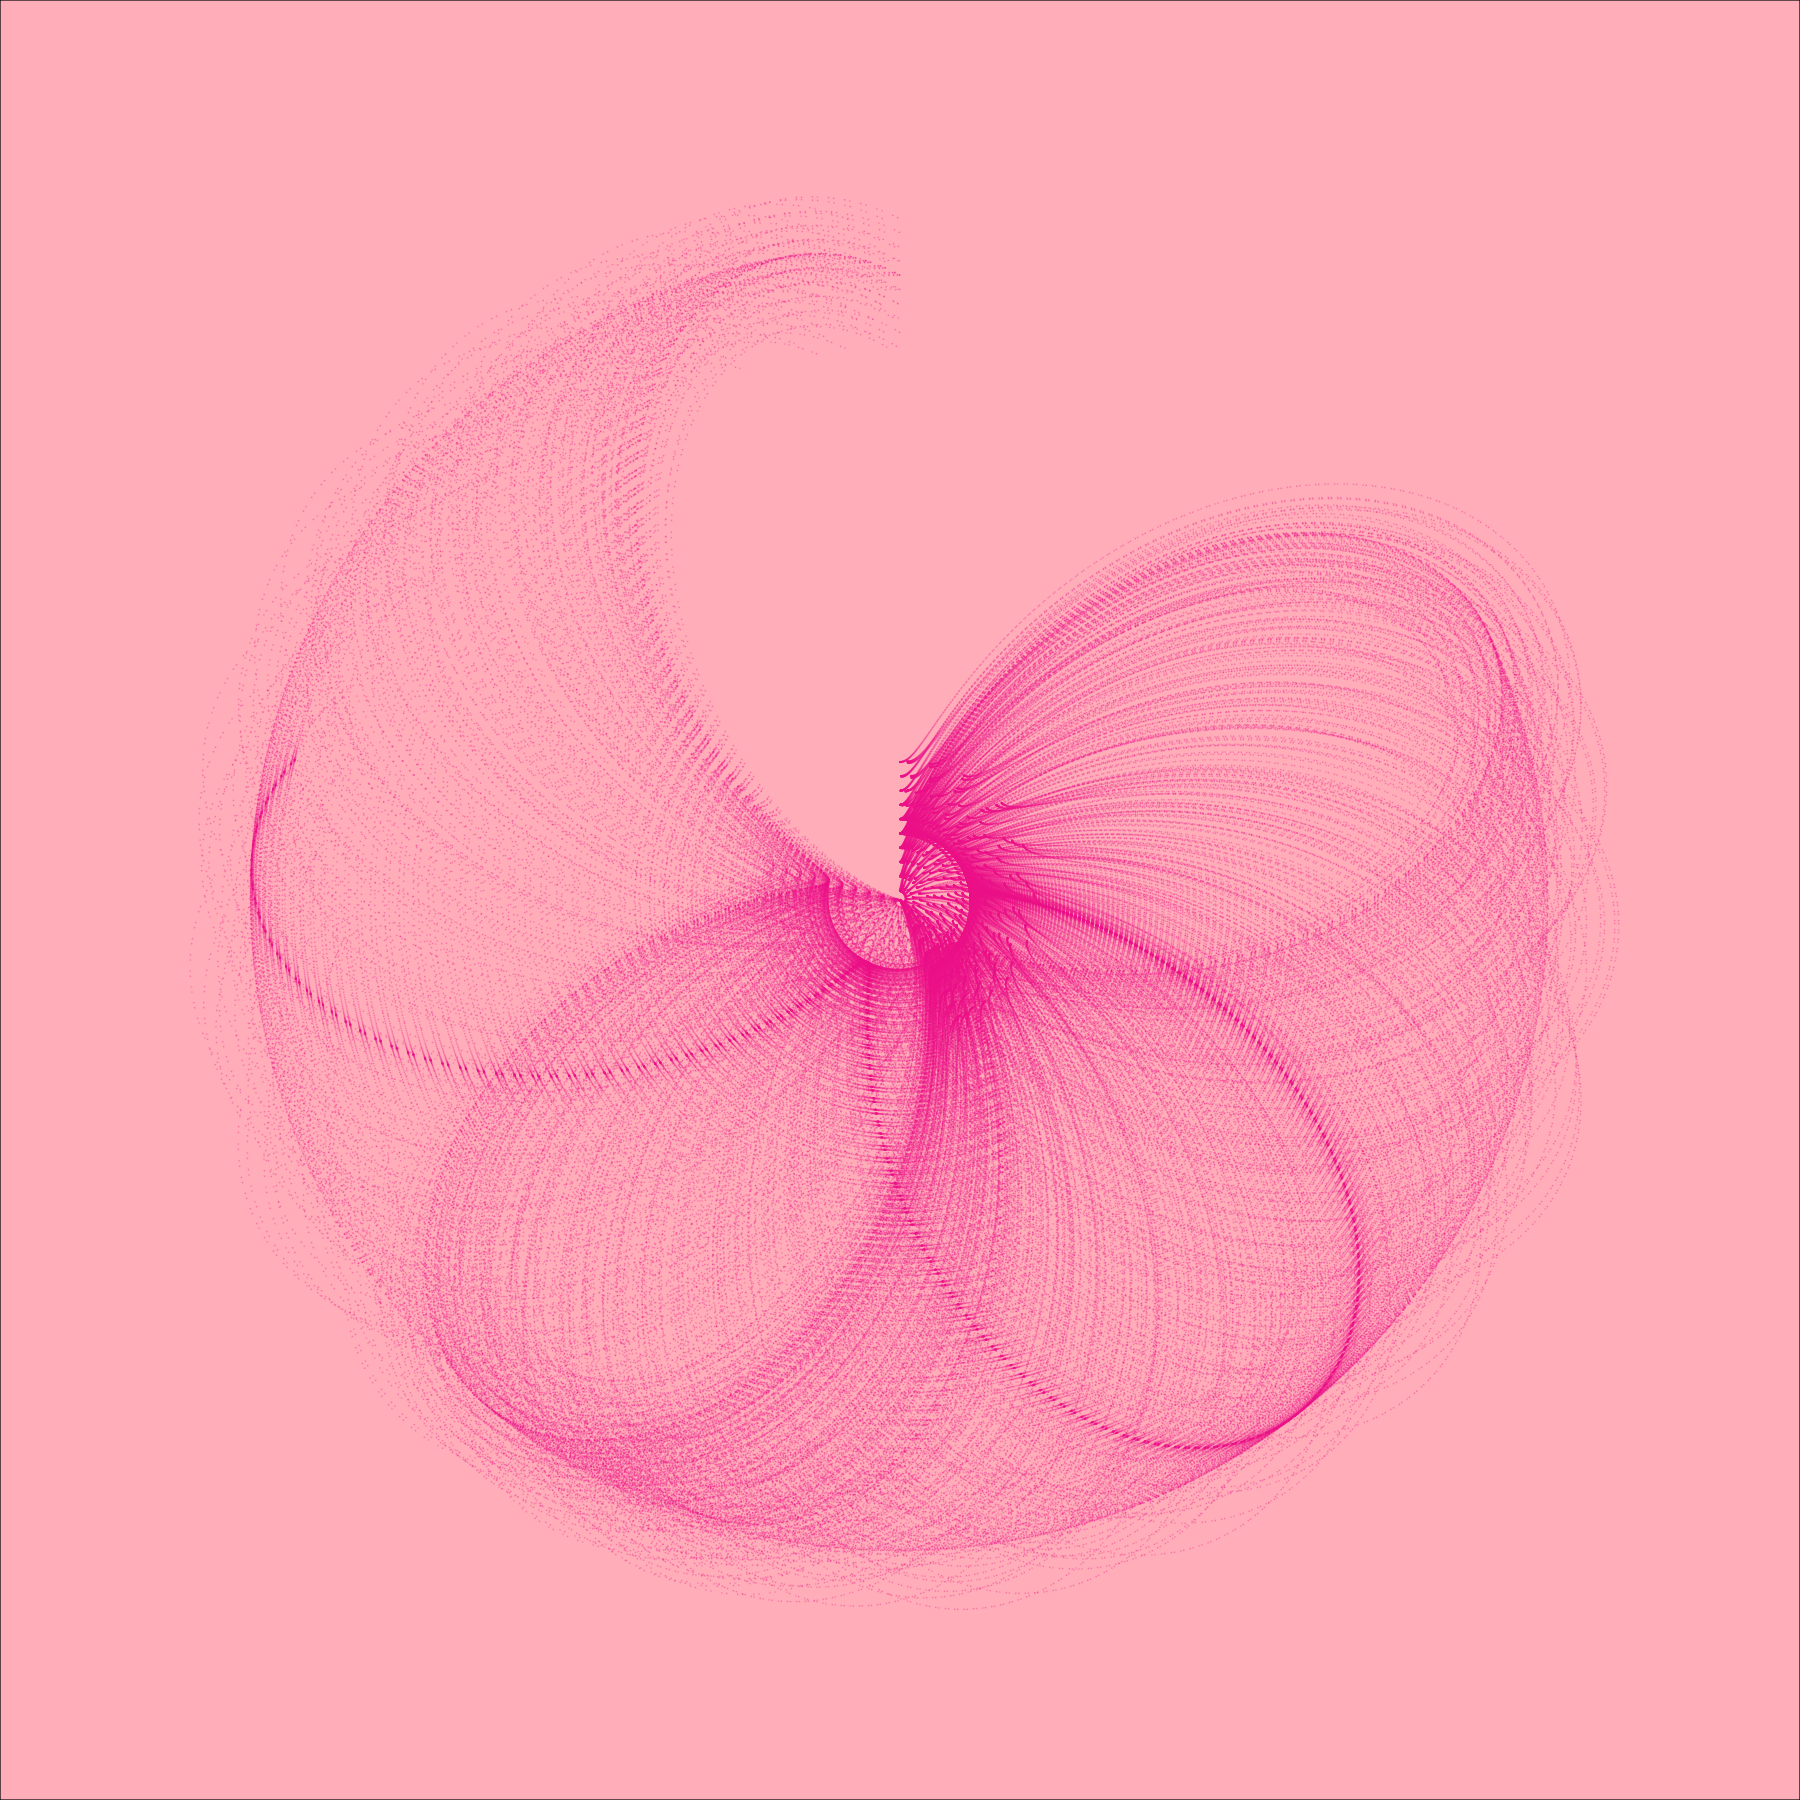

In [ ]:
options(repr.plot.width=15, repr.plot.height=15)
color = 'deeppink2'
background_color = 'lightpink1'
plot <- df %>%
  ggplot(aes(x = x, y = y)) +
  geom_point(alpha = 0.2, size = 0, shape = 20, color = color) +
  theme_void() +
  #coord_fixed() +
  coord_polar() +
  #ggtitle(paste('using seed ', seed )) + 
  theme(
    panel.background = element_rect(fill = background_color),
    plot.background = element_rect(fill = background_color)
    )
plot
#ggsave('generative_art_1.png')

# Make faster iterations by using a package
The code above was copied from a package called "generativeart". If you want to go through more seeds faster, you can create a new folder for yout art and make many images in one go as shown below.

In [ ]:
devtools::install_github("cutterkom/generativeart")
library(generativeart)

# set the paths
IMG_DIR <- "/content/generated_art/"
IMG_SUBDIR <- "everything/"
IMG_SUBDIR2 <- "handpicked/"
IMG_PATH <- paste0(IMG_DIR, IMG_SUBDIR)

LOGFILE_DIR <- "/content/generated_art/logfile/"
LOGFILE <- "logfile.csv"
LOGFILE_PATH <- paste0(LOGFILE_DIR, LOGFILE)

# create the directory structure
generativeart::setup_directories(IMG_DIR, IMG_SUBDIR, IMG_SUBDIR2, LOGFILE_DIR)

In [ ]:
# define your formula
my_formula <- list(
  x = quote(runif(1, -1, 1) * x_i^2 - sin(y_i^2)),
  y = quote(runif(1, -1, 1) * y_i^3 - cos(x_i^2))
)

In [ ]:
# have the package create 5 images with polar coordinate system and save them to your folder
generativeart::generate_img(formula = my_formula, nr_of_img = 5, polar = TRUE, filetype = "png", color = "black", background_color = "white")


# Using the mathart package


In [ ]:
library(mathart)
library(ggforce)
library(Rcpp)
library(tidyverse)


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.2.1     ✔ purrr   1.0.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
color = 'deeppink2'
background_color = 'lightpink1'

df2 <- harmonograph(A1 = 1, A2 = 1, A3 = 1, A4 = 1,
                    d1 = 0.0085, d2 = 0, d3 = 0.065, d4 = 0,
                    f1 = 2.01, f2 = 3, f3 = 3, f4 = 2,
                    p1 = 0, p2 = 7*pi/16, p3 = 0, p4 = 0) %>% mutate(id = 2)

p <- ggplot() +
  geom_path(aes(x, y), df2, alpha = 0.7, linewidth = 0.5, color=color) +
  coord_equal() +
  theme_blankcanvas(margin_cm = 0) +
  theme(
    panel.background = element_rect(fill = background_color),
    plot.background = element_rect(fill = background_color))

ggsave("harmonograph01.png", p, width = 20, height = 20, units = "cm")

In [ ]:
smooth_loess <- function(x, span) {
  n <- length(x)
  dat <- tibble(time = 1:n, walk = x)
  mod <- loess(walk ~ time, dat, span = span)
  predict(mod, tibble(time = 1:n))
}

perturb <- function(path, noise = .01, span = .1) {
  path |> 
    group_by(stroke) |>
    mutate(
      x = x + rnorm(n(), 0, noise),
      y = y + rnorm(n(), 0, noise),
      x = smooth_loess(x, span),
      y = smooth_loess(y, span),
      alpha = runif(n()) > .5,
      size = runif(n(), 0, .2)
    )
}

brush <- function(path, bristles = 100, seed = 1, ...) {
  set.seed(seed)
  dat <- list()
  for(i in 1:bristles) {
    dat[[i]] <- perturb(path, ...)
  }
  return(bind_rows(dat, .id = "id"))
}

stroke <- function(dat, geom = geom_path, colour = "white", ...) {
  dat |>  
    ggplot(aes(
      x = x, 
      y = y, 
      alpha = alpha, 
      size = size, 
      group = paste0(stroke, id)
    )) + 
    geom(
      colour = colour, 
      show.legend = FALSE,
      ...
    ) + 
    coord_equal() +
    scale_alpha_identity() +
    scale_size_identity() +
    theme_void() + 
    theme(plot.background = element_rect(
      fill = "#222222", 
      colour = "#222222"
    ))
}

In [ ]:
# from https://blog.k2h.se/post/generative-gravel/
square <- function() {
  tibble(x = 0.5 * c(1, -1, -1, 1),
         y = 0.5 * c(1, 1, -1, -1))
}

make_grid <- function(columns, rows) {
  tibble(square = 1:(columns * rows) - 1) %>% # Give each square a unique ID
                                              # Starting at 0 which simplifies the
                                              # calculations of column and row below
    mutate(points = map(square, ~ square())) %>%
    unnest(points) %>%
    mutate(column = square %% columns,
           row = square %/% columns)
}

spread_squares <- function(df, padding = 0.0) {
  df %>%
    mutate(x = x + column * (1 + padding),
           y = y + row * (1 + padding))
}

rotate <- function(df, angle) {
  df %>%
    mutate(xnew = x * cos({{angle}}) - y * sin({{angle}}),
           ynew = x * sin({{angle}}) + y * cos({{angle}}),
           x = xnew,
           y = ynew) %>%
    select(-xnew, -ynew)
}

set.seed(1)

df.result <- make_grid(10, 20) %>%
  mutate(noisiness = row / max(row)) %>%
  
  group_by(square) %>%
  mutate(angle = rnorm(1, 0, noisiness * (pi / 2))) %>%
  ungroup() %>%
  
  rotate(angle) %>%
  spread_squares(padding = 0.2) %>%
  
  group_by(square) %>%
  mutate(x = x + rnorm(1, 0, noisiness ^ 2 * 0.3),
         y = y + rnorm(1, 0, noisiness ^ 2 * 0.3)) %>%
  ungroup() 



Saving 6.67 x 6.67 in image


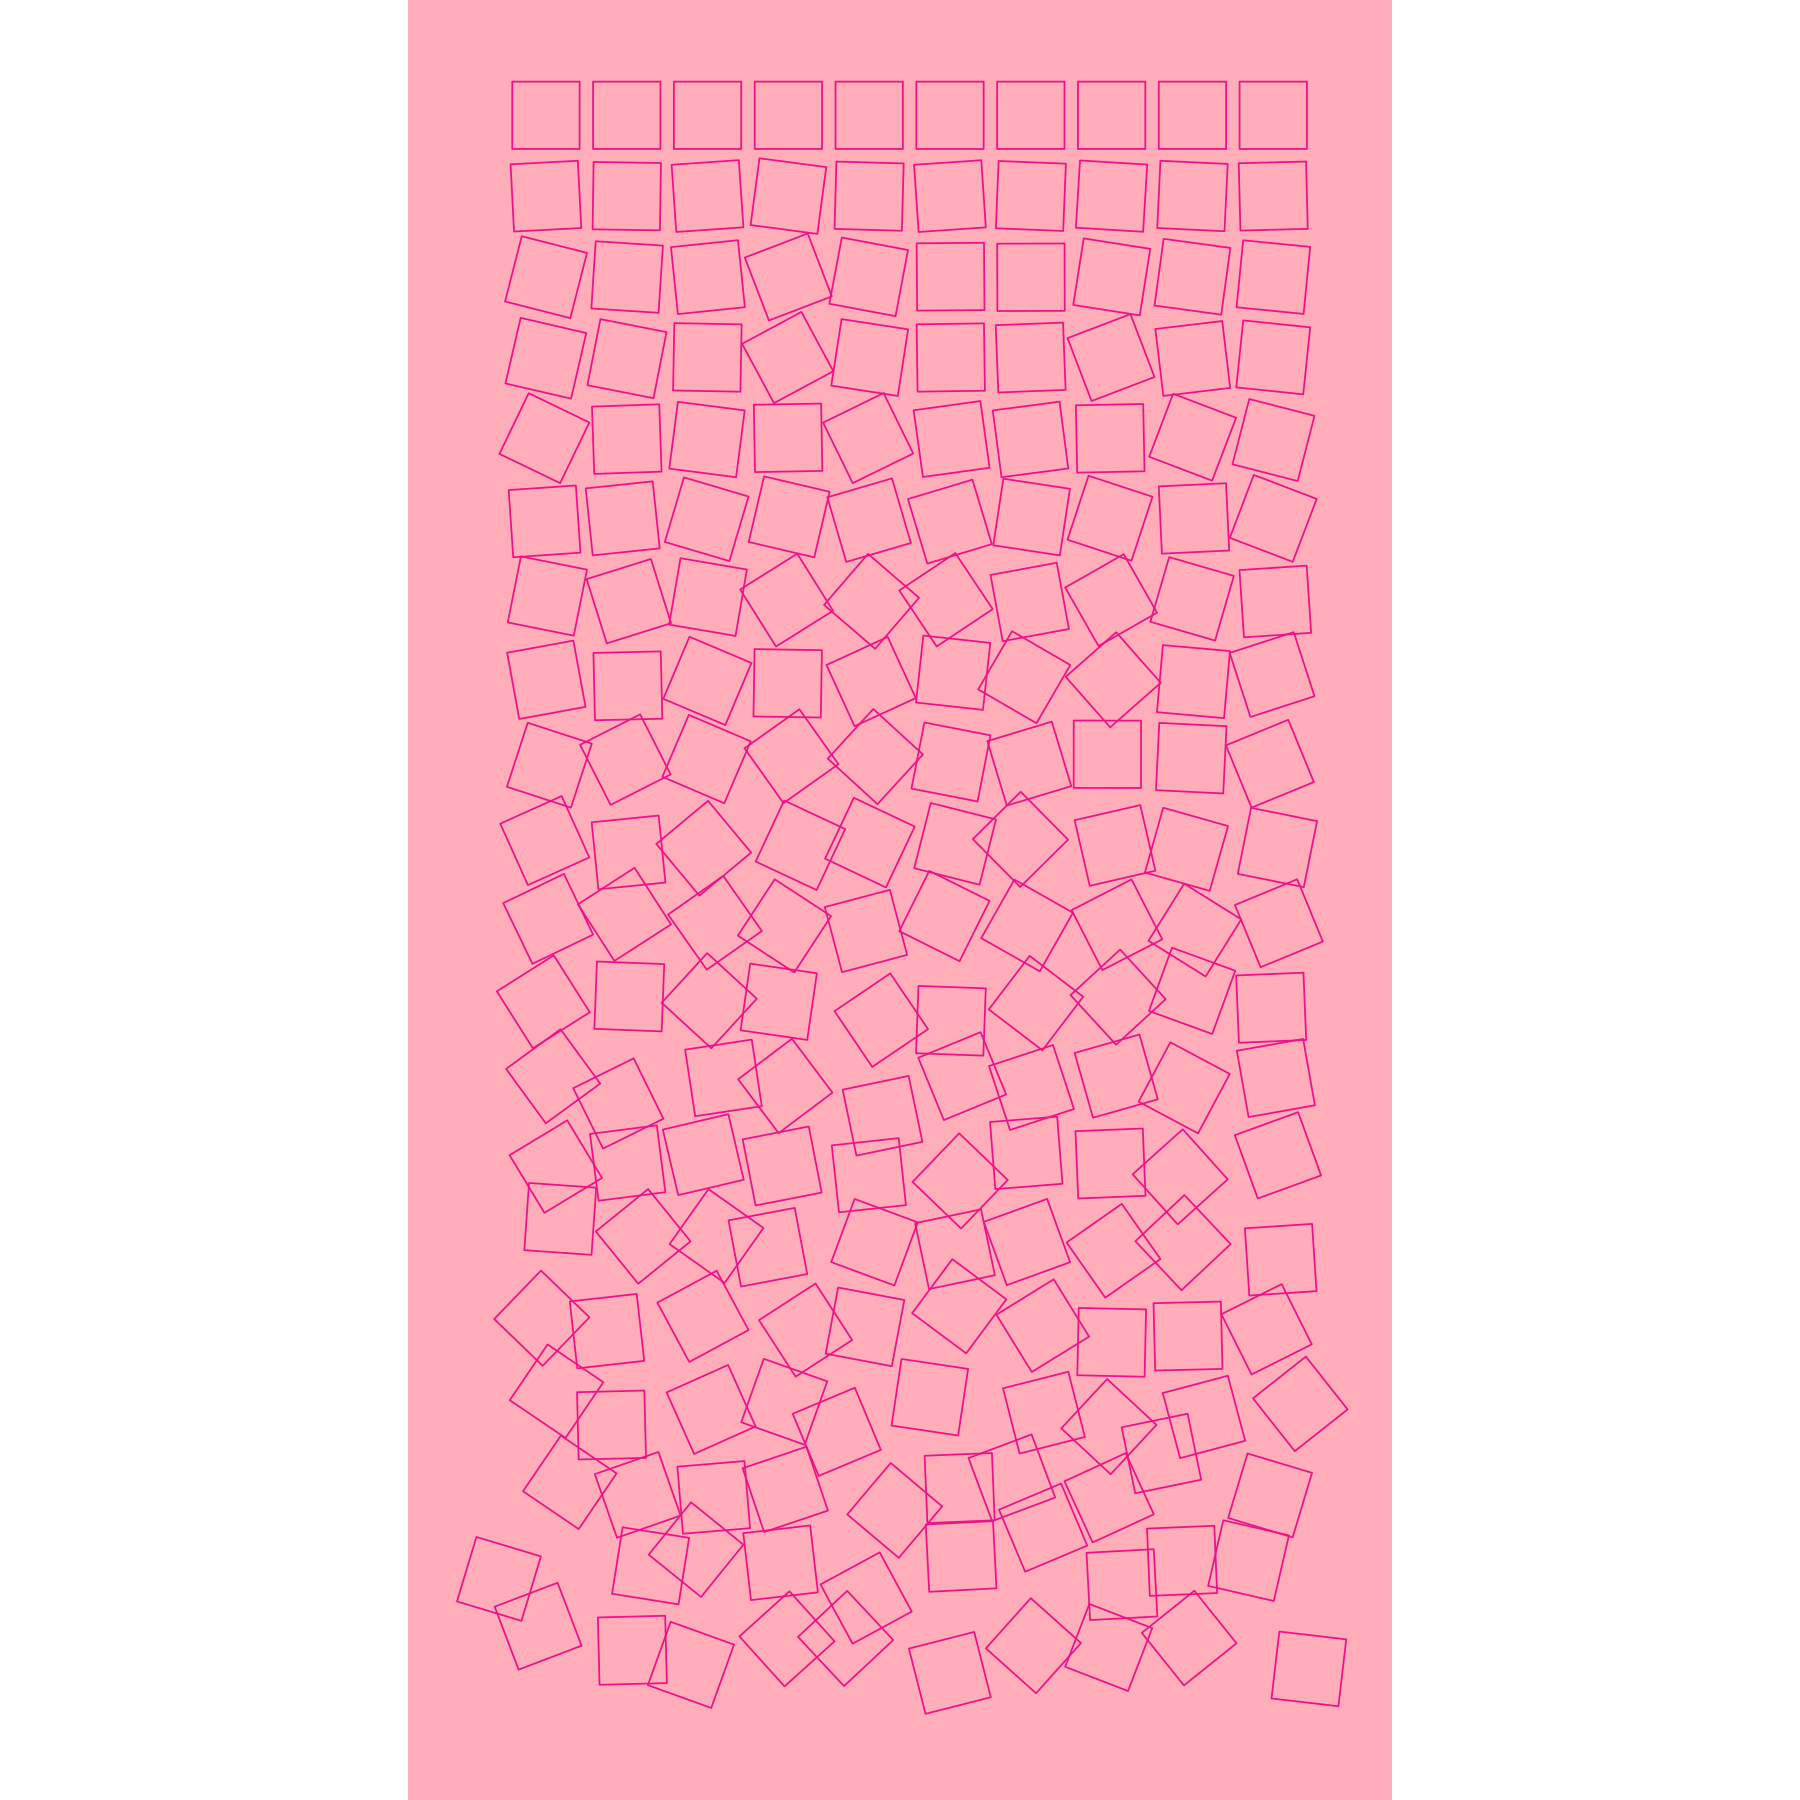

In [ ]:
color = 'deeppink2'
background_color = 'lightpink1'
df.result %>%
  ggplot(aes(x, y, group = square)) +
    geom_polygon(fill = NA, color = color) +
    coord_equal() +
    scale_y_continuous(trans = 'reverse') +
    theme_blankcanvas(margin_cm = 0) +
      theme(
    panel.background = element_rect(fill = background_color),
    plot.background = element_rect(fill = background_color)
    )

  ggsave('squares.png')

In [ ]:
df.result 

In [ ]:
install.packages('ambient')
library(ambient)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘ambient’


The following object is masked _by_ ‘.GlobalEnv’:

    rotate




In [ ]:
# again from danielle navarro



update_curl <- function(current_state, step_size = .0005, ...) {
  curl <- curl_noise(
    x = current_state$x, 
    y = current_state$y,
    ...
  )
  next_state <- current_state |>
    mutate(
      x = x + curl$x * step_size,
      y = y + curl$y * step_size,
      time = time + 1
    )
  return(next_state)
}




In [ ]:
seed_now = 1133

coords <- seq(0, 1, length.out = 50)
time_1 <- long_grid(x = coords, y = coords) |> 
  mutate(id = row_number(), time = 1)

time_2 <- time_1 |>
  update_curl(
    generator = gen_simplex,
    frequency = 10, 
    seed = seed_now
  )

time_3 <- time_2 |> 
  update_curl(
    generator = gen_simplex,
    frequency = 10, 
    seed = seed_now
  )

time_4 <- time_3 |> 
  update_curl(
    generator = gen_simplex,
    frequency = 10, 
    seed = seed_now
  )

#time_3
#time_1

Saving 6.67 x 6.67 in image


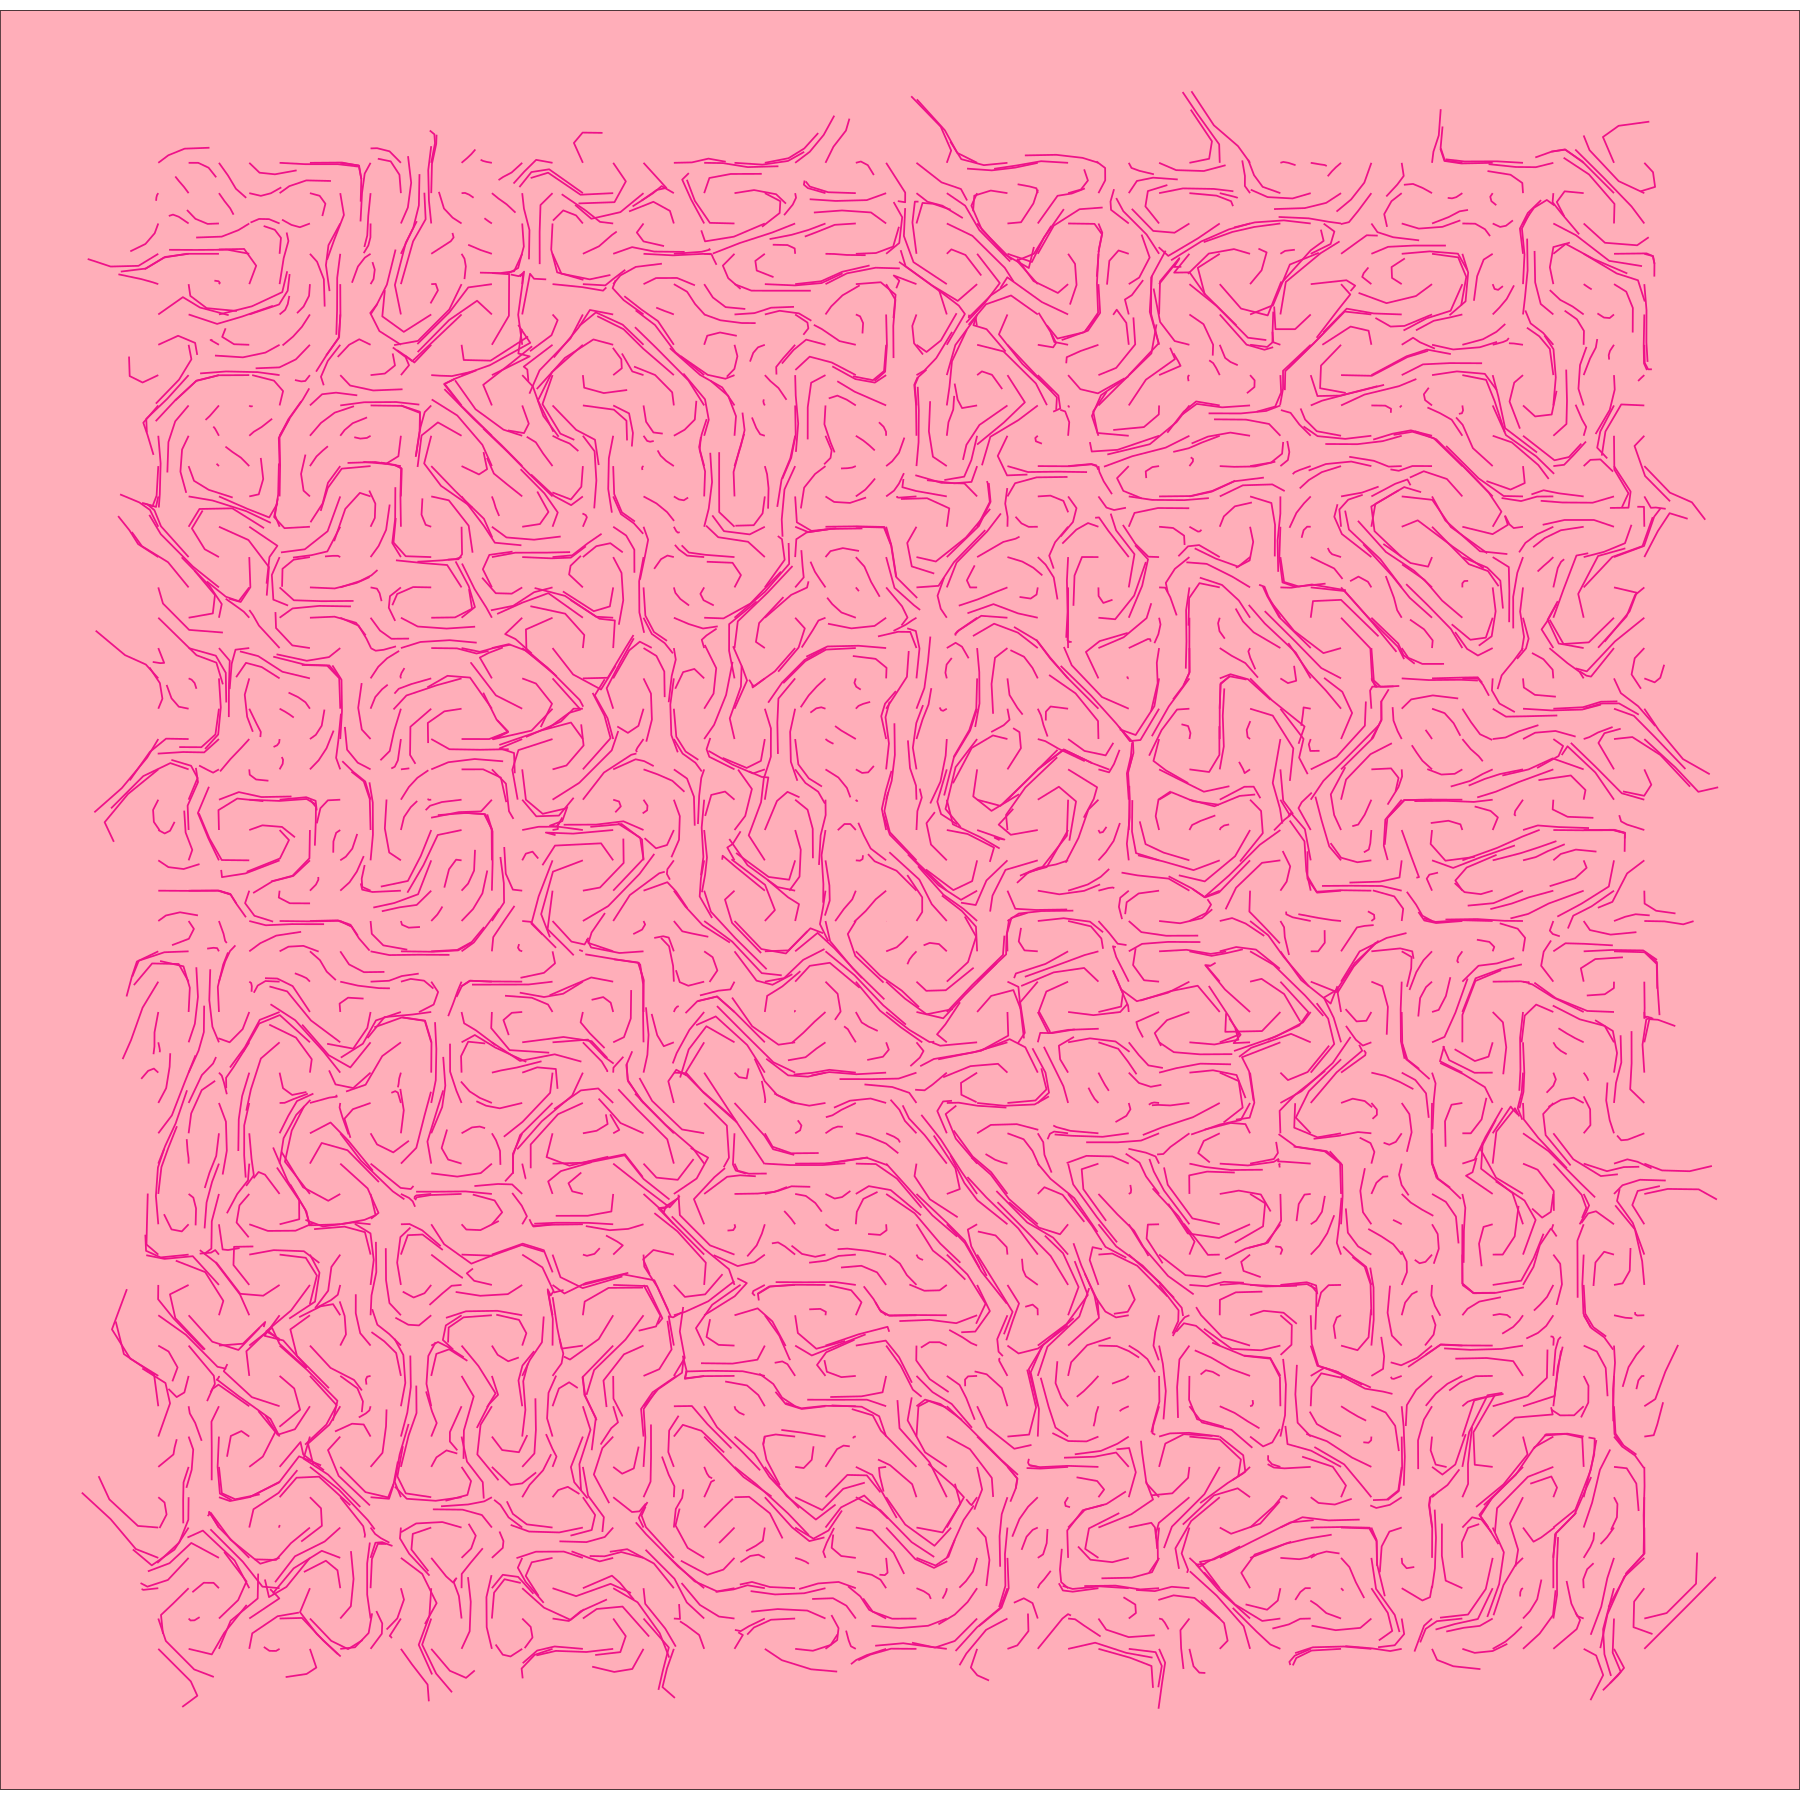

In [ ]:
dat123 <- bind_rows(time_1, time_2, time_3, time_4)

dat123 |>
  ggplot(aes(x, y, group = id)) + 
  geom_path(colour = color) +
  theme_void() + 
  coord_equal() +
    theme(
    panel.background = element_rect(fill = background_color),
    plot.background = element_rect(fill = background_color)
    )
  ggsave('curl_stuff.png')

# Advanced module 
If you already have some coding experience, the exercises above may seem a little simplistic as we use them to get familiar with concepts such as functions, arguments and axes. You're welcome to follow along the workshop as is, but if you're keen to go faster and try out more things, you can also try your hand at exercises below. 

## R syntactic quirks
Here's a few quirks about R syntax, that might help you along the way. 
1. Indexing starts from 1, not 0
2. Indentation doesn't matter for code execution.
3. Both `<-` and `=` can be used to assign values to variables. I will be mostly using `<-` as it is the R "canonical way" and may be more understandable for beginners but `=` works just as well.
4. The 'magrittr pipe'` %>%` (part of tidyverse family of packages; here imported via the package dplyr) is used to combine multiple commands to a sequence. It works similarly to a | pipe on the command line or '.' in pandas: it takes the output of the left hand side of the pipe and feeds it as the first parameter to the function on the right hand side of the pipe.
5. Many of the plotting libraries used for generating art build on something called "Grammar of Graphics" (package ggplot2). Here, the different "layers" (e.g. type of plot, name of title, settings for the axes etc) are combined via a plus sign (`+`) 
6. Vectors are created with the function `c()` (c stands for combine)


## aRtsy

One fantastic package for creating multiple different types of generative art is called aRtsy. In this task, you will create one or more pieces of art using the aRtsy package.
1. Check out [the aRtsy package website](https://koenderks.github.io/aRtsy/)
2. Pick out one of the art functions that appeals to you visually
3. Play around with the parameters to the function (+ test different random seeds) to create something you think looks great
4. Save your end result
5. Please share your creation with others in the event Slack! 

Tip: [The color palettes natively available at aRtsy](https://koenderks.github.io/aRtsy/#color-palettes) are listed at the bottom of the aRtsy website

## Mathart
Another fantastic pakcage for generative art focusing on mathematic phenomena is a package called Mathart.

1. Check out the [mathart github repo](https://github.com/marcusvolz/mathart
)
2. Pick out one of the example images that appeals to you visually
3. Tweak the parameters to test how they impact the end result. 
Tip: Note that you may have to do smaller changes to parameter values here than you did in aRtsy due to the complex mathematical formulae involved. I recommend starting with the default parameters and, once you see how the plot looks with those, trying to tweak the values a little bit, one at a time.
4. Save your end result
5. Please share your creation with others in the event Slack! 

Tip: here, you may want to specify a particular color for the output. Mathart itself does not have built-in packages but it uses the ggplot2 package which knows the following [color name definitions](http://sape.inf.usi.ch/quick-reference/ggplot2/colour). You can also define color by its HEX code or RGB value [(see e.g. here for some examples)](https://bookdown.org/hneth/ds4psy/D-5-apx-colors-define-use-custom.html)